# 피처 메이킹 전 과정
 - 두번째 파이프 라인은 데이터로부터 예측 모델 훈련에 사용할 피처를 만들어내는 '피처 메이킹 전 과정'입니다.  
    
         - 1. 대회측에서 제공한 기본 데이터를 어떻게 가공할까에 대해서 댄드로그램을 적용하여 피처를 만들었습니다.  
         - 2. 앞서 수집한 4가지 종류의 데이터에 대해서 해당 데이터들이 종속변수인 유입량을 예측하기 위해서 유의미한지를  
              살펴보는 검증과정을 거쳐 데이터를 선택하였습니다.
         - 3. 생성한 피처, 수집한 데이터, 기본 데이터를 모두 합하여 가장 기본 성능이 잘 나오는 데이터 조합을  
              뽑아내기 위해서 피처 설렉션과정을 거쳤습니다.
         - 이렇게 크게 3가지 과정을 거쳐서 다음 파이프라인인 모델링에 사용할 훈련 데이터를 만들어내었습니다.


***

In [1]:
# Data Handling
import pandas as pd
import numpy as np


# OS
import os
import time
import warnings;warnings.filterwarnings('ignore')
from tqdm import tqdm


# Visualization
import matplotlib.pyplot as plt
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
import klib


# Preprocessing & Feature Engineering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import itertools
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import KFold


# Statistics
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import scipy.stats as stats


# Modeling
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


# Evaluation
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score


Bad key "text.kerning_factor" on line 4 in
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 1. 댄드로그램

In [2]:
data = pd.read_csv('./data/data.csv')   # 3051 x 48
train = pd.read_csv('./data/train.csv') # 2891 x 48
dendro_df = pd.DataFrame()

-  댄드로그램 함수 정의
      1. 함수를 ward 기준으로 댄그로그램 수행
      2. 댄그로그램을 그려본 후 어떻게 집단을 나눌 것인지 기준 설정, 기준에 따른 데이터 프레임 반환

In [3]:
def dendrogram_fuction(regex, cut_criterion):
    clust_ward = linkage(data.filter(regex=regex).iloc[:2891,:].transpose(), method='ward')
    columns = data.filter(regex=regex).iloc[:2891,:].columns
    dendrogram(clust_ward, labels=columns, show_leaf_counts=True, leaf_rotation=90, leaf_font_size=10 )
    plt.axhline(y=cut_criterion, xmin=0, xmax=25, color='black')
    plt.show()
    
    den = data.filter(regex=regex).transpose()
    cut_tr = int(input('cut_tree: '))
    den['댄드로그램'] = list(itertools.chain.from_iterable(cut_tree(clust_ward, cut_tr).tolist()))
    den = den.groupby('댄드로그램').mean().transpose()
    col = []
    for i in range(cut_tr):
        col.append(f'{regex}_{i}집단')
    den.columns = col
    return pd.concat([dendro_df,den],axis=1)

강우 데이터집단은 각 지역별로 군집화되는 것을 알 수 있음. 군집화되어 4개의 집단(강우_0집단 ~ 강우_3집단)을 생성함 

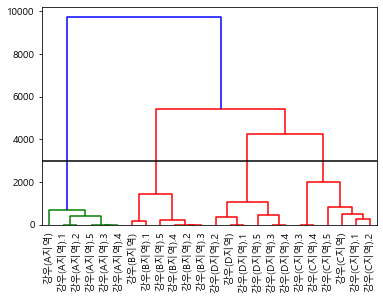

cut_tree: 4


,강우_0집단,강우_1집단,강우_2집단,강우_3집단
0,7.000000,7.0,7.500000,8.000000
1,7.000000,8.0,8.500000,9.000000
2,7.000000,9.0,8.666667,9.500000
3,8.000000,10.0,11.666667,11.333333
4,10.166667,12.0,13.666667,13.166667


In [4]:
dendro_df = dendrogram_fuction('강우', 3000)
dendro_df.head()

수위 데이터집단도 각 지역별로 군집화 되고, 2개의 집단(수위_0집단, 수위_1집단)을 생성함

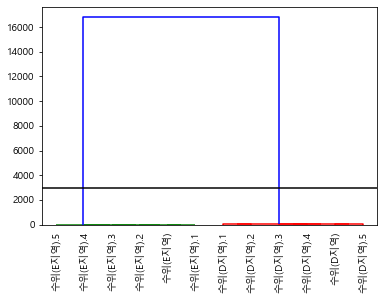

cut_tree: 2


,강우_0집단,강우_1집단,강우_2집단,강우_3집단,수위_0집단,수위_1집단
0,7.000000,7.0,7.500000,8.000000,2.54,122.600903
1,7.000000,8.0,8.500000,9.000000,2.53,122.597782
2,7.000000,9.0,8.666667,9.500000,2.53,122.594661
3,8.000000,10.0,11.666667,11.333333,2.53,122.592748
4,10.166667,12.0,13.666667,13.166667,2.53,122.587423


In [5]:
dendro_df = dendrogram_fuction('수위', 3000)
dendro_df.head()

유역평균강수 데이터집단에서는 데이터 집단 2와 3이 같은 곳으로 묶였음. 군집화를 바탕으로 5개의 집단(유역평균강수_0집단 ~ 유역평균강수_4집단)을 생성함

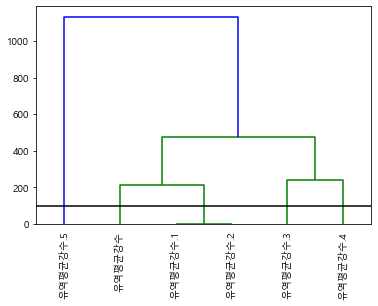

cut_tree: 5


,강우_0집단,강우_1집단,강우_2집단,강우_3집단,수위_0집단,수위_1집단,유역평균강수_0집단,유역평균강수_1집단,유역평균강수_2집단,유역평균강수_3집단,유역평균강수_4집단
0,7.000000,7.0,7.500000,8.000000,2.54,122.600903,6.4,6.3,6.4,6.4,6.4
1,7.000000,8.0,8.500000,9.000000,2.53,122.597782,6.3,6.4,7.3,7.3,7.3
2,7.000000,9.0,8.666667,9.500000,2.53,122.594661,6.4,7.3,8.2,8.2,8.2
3,8.000000,10.0,11.666667,11.333333,2.53,122.592748,7.3,8.2,11.3,11.3,11.3
4,10.166667,12.0,13.666667,13.166667,2.53,122.587423,8.2,11.3,14.4,14.4,14.4


In [6]:
dendro_df = dendrogram_fuction('유역평균강수', 100)
dendro_df.head()

In [7]:
# 데이터 저장
dendro_df.to_csv('./data/Dendrogram.csv', index=False)
# 데이터 확인
pd.read_csv('./data/Dendrogram.csv') # 3051 x 11

,강우_0집단,강우_1집단,강우_2집단,강우_3집단,수위_0집단,수위_1집단,유역평균강수_0집단,유역평균강수_1집단,유역평균강수_2집단,유역평균강수_3집단,유역평균강수_4집단
0,7.000000,7.0,7.500000,8.000000,2.54,122.600903,6.4000,6.3000,6.4000,6.4000,6.4000
1,7.000000,8.0,8.500000,9.000000,2.53,122.597782,6.3000,6.4000,7.3000,7.3000,7.3000
2,7.000000,9.0,8.666667,9.500000,2.53,122.594661,6.4000,7.3000,8.2000,8.2000,8.2000
3,8.000000,10.0,11.666667,11.333333,2.53,122.592748,7.3000,8.2000,11.3000,11.3000,11.3000
4,10.166667,12.0,13.666667,13.166667,2.53,122.587423,8.2000,11.3000,14.4000,14.4000,14.4000
...,...,...,...,...,...,...,...,...,...,...,...
3046,1.000000,0.0,0.333333,0.000000,3.16,129.963927,2.3689,2.3689,2.3689,2.3689,2.1722
3047,1.000000,0.0,0.333333,0.000000,3.15,129.975113,2.3689,2.3689,2.3689,2.3689,2.0805
3048,1.000000,0.0,0.333333,0.000000,3.13,129.982202,2.3689,2.3689,2.3689,2.3689,2.0354
3049,1.000000,0.0,0.333333,0.000000,3.11,129.989292,2.3689,2.3689,2.3689,2.3488,1.8993


# 2. 수집한 데이터에 대한 통계적 검정 및 데이터 선택 

In [8]:
# 데이터 로드
target = pd.read_csv('./data/target.csv')
collected_data = pd.read_csv('./data/수집데이터셋.csv')


# 일부 object 칼럼 float 타입으로 변경
def to_float(df):
    df = df.applymap(lambda x : float(x.replace(',', '')) if type(x) == np.str else float(x))
    return df
collected_data = to_float(collected_data)

- 수집된 데이터들이 종속변수(유입량)와 **선형의 상관관계**를 갖는지를 파악하기 위해 피어슨 상관계수를 통해 검증을 진행함. 

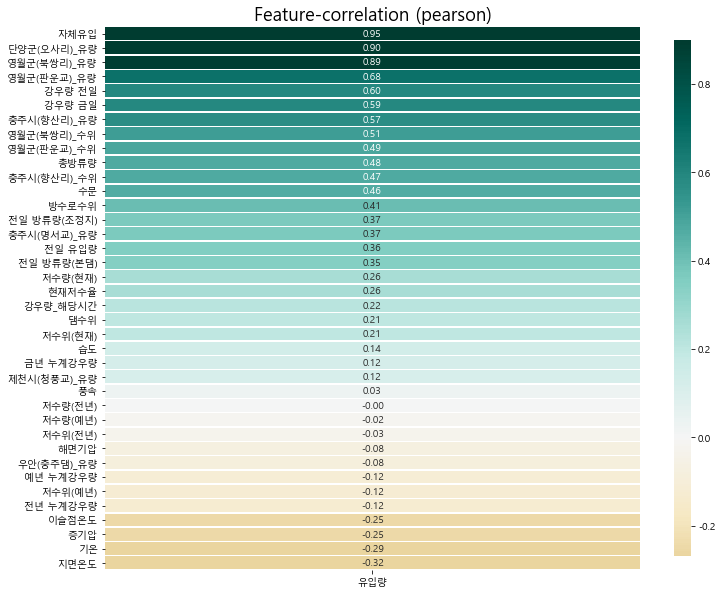

In [9]:
collected_temp = collected_data.copy()
collected_temp['유입량'] = target
klib.corr_plot(data = collected_temp.iloc[:2891, :-1], target=collected_temp['유입량'])
plt.show()

- P-value가 0.05를 넘으면 해당 상관계수가 신뢰할 수 없는 것으로 판단함. 
- 상관계수가 높은 독립변수들의 P-value가 충분히 낮은 것을 확인하여 해당 상관계수가 신뢰할 만 하다는 결론을 도출함.


In [10]:
collected_train = collected_data.iloc[:2891, :]

lst_corr = []
lst_pvalue = []
for column in collected_train.columns.tolist():    
    lst_corr.append(stats.pearsonr(collected_train[column].values, target.values.flatten())[0])
    lst_pvalue.append(stats.pearsonr(collected_train[column].values, target.values.flatten())[1])

pd.DataFrame({'Feature_names': collected_train.columns, '상관계수': lst_corr, 'P-value': lst_pvalue}).sort_values('상관계수', ascending=False)

,Feature_names,상관계수,P-value
35,자체유입,0.953016,0.000000e+00
7,단양군(오사리)_유량,0.903840,0.000000e+00
9,영월군(북쌍리)_유량,0.889863,0.000000e+00
11,영월군(판운교)_유량,0.679916,0.000000e+00
18,강우량 전일,0.597205,4.944459e-279
17,강우량 금일,0.591786,8.897957e-273
16,충주시(향산리)_유량,0.573531,1.484348e-252
8,영월군(북쌍리)_수위,0.514097,8.177169e-195
10,영월군(판운교)_수위,0.492793,9.141286e-177
36,총방류량,0.476228,1.369623e-163


  - 앞서 외부데이터와 종속변수 간의 선형관계가 존재하는지 파악했다면, **비선형적인 관계가 	  존재하는지 파악하기 위해** 선형성 파악보다 더 일반적으로 두 변수 간의 종속관계를 		  확인할 수 있는  **Mutual Information Regression Score를 사용해 검증을 진행**함.
  - Mutual Information Regression Score 가 0.8 이하일 시 해당 독립변수와 종속변수 간의 관계가 없다고 판단함.


In [11]:
# SelectKBest로 비모수 추정법 사용
selector = SelectKBest(mutual_info_regression, k = 'all') # k는 선택할 변수의 갯수
X_new = selector.fit_transform(collected_train, target)


# 비선형적 관계를 살펴보기 위한 점수 추출
column_names = collected_train.columns.values[selector.get_support()]
mutual_scores = selector.scores_[selector.get_support()]
names_scores = list(zip(column_names, mutual_scores))


## 데이터 프레임 정의
mir_df = pd.DataFrame(data = names_scores, columns=['Feature_names', 'Mutual_Scores'])
mir_df_sorted = mir_df.sort_values(['Mutual_Scores'], ascending=False)
mir_df_sorted

,Feature_names,Mutual_Scores
7,단양군(오사리)_유량,1.728736
9,영월군(북쌍리)_유량,1.435555
35,자체유입,1.393281
8,영월군(북쌍리)_수위,1.349948
19,금년 누계강우량,1.277394
11,영월군(판운교)_유량,1.247540
21,예년 누계강우량,1.236847
32,댐수위,1.229670
25,저수위(현재),1.228138
28,저수량(현재),1.209697


 - 검증결과  
독립변수들과 종속변수 사이의 선형적 상관관계와 비선형적 상관관계를 모두 파악한 결과 **pearson 상관계수에서 절댓값이 0.2를 넘지 못하고 Mutual Information score에서 0.8을 동시에 넘지 못하는 독립변수를 찾아 제거함**

In [12]:
# 제거 대상 피처 3개
drop_lst = ['습도', '풍속', '해면기압']
collected_data.drop(drop_lst, axis=1, inplace=True)

 - 독립변수 간의 상관관계 검증  
독립변수들 간의 상관관계가 너무 높을 경우 발생하는 다중공선성 문제를 해결하기 위해 피어슨 상관계수를 통해 이를 확인하고 제거하고자 함. 

Displaying absolute correlations above the threshold (0.9). Specify a positive "threshold" to limit the results further.


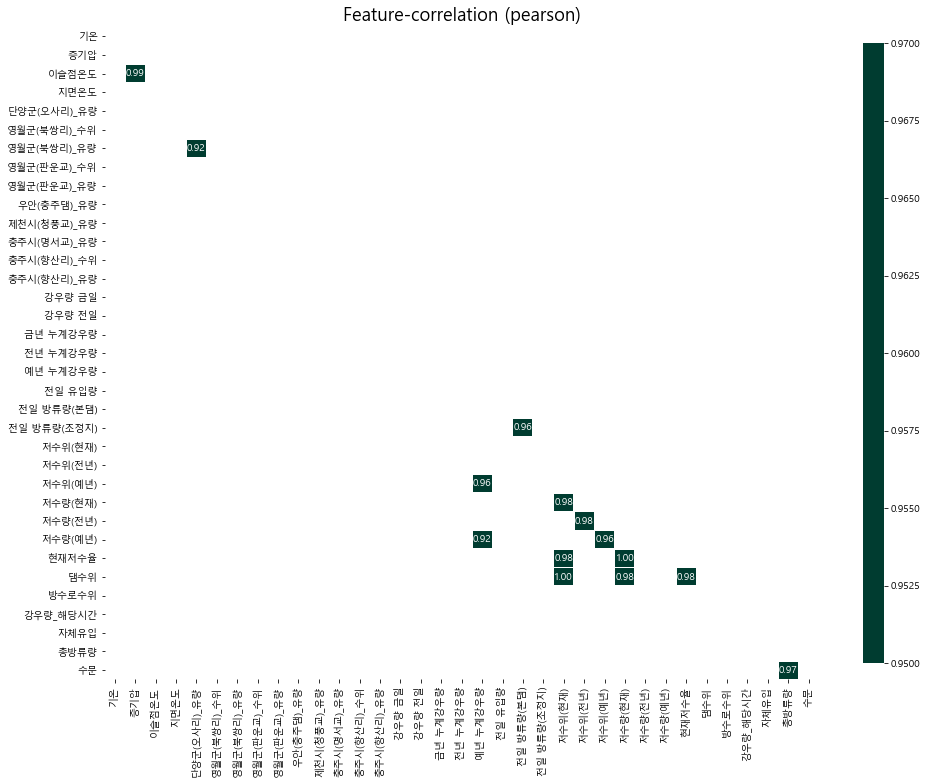

In [13]:
klib.corr_plot(collected_data, figsize = (16,12), split='high', threshold = 0.9)
plt.show()

 - 검증결과  
**상관계수가 0.9 이상인 독립변수 쌍**을 다수 발견하여, **둘 중 하나의 변수를 제거**함. 제거 시에는 두 독립변수 중 종속변수와 상관관계가 더 낮은 독립변수를 우선적으로 제거함.


In [14]:
# 제거 피처 대상 10개
drop_lst = [
    '이슬점온도', '영월군(북쌍리)_유량', '전일 방류량(본댐)', '예년 누계강우량',
    '수문', '댐수위', '저수위(현재)', '저수량(전년)', '저수위(예년)', '현재저수율'
]
collected_data.drop(drop_lst, axis=1, inplace=True)

- 검증되어 선별된 데이터만 저장


In [16]:
collected_data.to_csv('./data/수집및검증된데이터셋.csv', index=False)
pd.read_csv('./data/수집및검증된데이터셋.csv')

,기온,증기압,지면온도,단양군(오사리)_유량,영월군(북쌍리)_수위,영월군(판운교)_수위,영월군(판운교)_유량,우안(충주댐)_유량,제천시(청풍교)_유량,충주시(명서교)_유량,...,전년 누계강우량,전일 유입량,전일 방류량(조정지),저수위(전년),저수량(현재),저수량(예년),방수로수위,강우량_해당시간,자체유입,총방류량
0,22.314286,23.078571,12.700000,2.54,61.50,23.60,1.51,122.65,122.63,0.99,...,585.7,228.8,469.5,128.92,1123.1,1093.9,66.74,0.4,143.889,0.00
1,22.385714,23.500000,22.242857,2.53,61.50,23.60,1.51,122.63,122.62,1.00,...,585.7,228.8,469.5,128.92,1121.5,1093.9,69.94,0.9,129.754,560.87
2,21.642857,23.500000,12.700000,2.53,61.50,23.60,1.51,122.59,122.59,1.01,...,585.7,228.8,469.5,128.92,1119.4,1093.9,70.03,0.9,97.138,671.58
3,21.128571,22.642857,12.700000,2.53,61.50,23.60,1.51,122.56,122.55,1.01,...,585.7,228.8,469.5,128.92,1117.9,1093.9,70.13,3.1,268.040,698.04
4,21.128571,21.785714,12.700000,2.53,61.50,23.60,1.51,122.54,122.51,1.01,...,585.7,228.8,469.5,128.92,1116.9,1093.9,70.13,3.1,416.401,703.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,20.937500,14.025000,27.112500,3.16,78.99,52.66,1.62,129.92,130.05,1.15,...,421.0,979.3,320.4,127.10,1395.5,936.5,69.92,0.0,26.571,580.18
3047,19.975000,13.675000,24.037500,3.15,77.63,52.66,1.62,129.93,130.01,1.15,...,421.0,979.3,320.4,127.10,1396.2,936.5,69.92,0.0,757.916,573.47
3048,18.912500,13.337500,21.550000,3.13,76.28,46.39,1.54,129.91,130.03,1.15,...,421.0,979.3,320.4,127.10,1395.5,936.5,69.89,0.0,396.623,581.07
3049,18.012500,13.262500,19.925000,3.11,74.93,50.26,1.59,129.90,129.99,1.14,...,421.0,979.3,320.4,127.10,1394.2,936.5,70.00,0.0,228.407,597.30


# 3. 피처 설렉션(Feature Selection)

In [32]:
# 원본데이터, 수집한 데이터, 만든 피처를 모두 불러와 통합함
data = pd.read_csv('./data/data.csv') # 3051 x 48
collected_dataset = pd.read_csv('./data/수집및검증된데이터셋.csv') # 3051 x 25
dendrogram_feature = pd.read_csv('./data/Dendrogram.csv') # 3051 x 11

total_data = pd.concat([data, collected_dataset, dendrogram_feature], axis=1).iloc[:, 6:] # 3051 x 78


# 피처 설렉션을 위해서 데이터셋을 나눔
trainset = total_data.iloc[:2891, :]
testset = total_data.iloc[2891:, :]

**ExtraTrees selection**

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:45<00:00,  1.74s/it]

(93, 880.2352814163789)


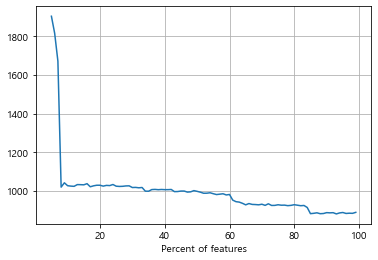

In [10]:
extra_reg = ExtraTreesRegressor(n_jobs=-1)
model = extra_reg    

cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(trainset.values, target.values)
    if X_new.shape[1] == 0: continue 
    cv_score = cross_val_score(model, X_new, target.values, scoring='neg_mean_squared_error', cv=5)
    rmse_score_mean = (np.sqrt((-cv_score).mean()))
    cv_scores.append((p, rmse_score_mean))

# Print the best percentile
best_score = cv_scores[np.argmin([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()
plt.show()

- LGBM, XGB, ExtraTrees 모델들 중 ExtraTrees모델에서 p가 93퍼일 때 가장 좋은 성능이 나와 해당 p와 그때의 피처를 채택함

In [11]:
# 93퍼센트의 trainset을 추출함
selected_p = SelectPercentile(percentile=best_score[0]).fit(trainset, target)
selected_train = selected_p.transform(trainset)


# 선택된 피쳐의 열 이름을 추출함
feature_idx = selectp.get_support()
feature_name = trainset.columns[feature_idx].tolist()


# 최종적으로 모델에 사용할 훈련데이터와 테스트 데이터를 결정함
X_test = testset[feature_name]
X_train = pd.DataFrame(selected_train,columns = feature_name)


# 데이터 저장
X_test.to_csv('./data/extra_select_test.csv',index=False)
X_train.to_csv('./data/extra_select_train.csv',index=False)

# ───────────────── End of Pipeline 2/4  ─────────────────